In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage.interpolation import zoom


fname = 'einstein.jpeg'
i_width = 640
i_height = 480

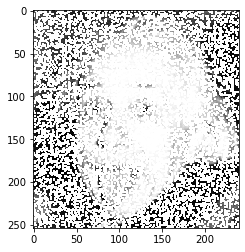

(254, 240)

In [2]:

sampling_threshold = 0.8

image = zoom(np.asarray(Image.open(fname).convert("L")), 0.2).astype(np.float)


image_ss = image.copy()
mask = np.random.uniform(size=image.shape) < 1- sampling_threshold
image_ss[mask] = np.nan
plt.imshow(image_ss, cmap='gray', vmin=0, vmax=255)
plt.show()
image_ss.shape

In [3]:
# test set 
image[mask]
# train set
image[~mask]

array([89., 98., 87., ..., 26., 57., 51.])

In [72]:
#a
y_train = image_ss[~mask]
X_train = np.array([(i,j) for i in range(254) for j in range(240) if np.isnan(image_ss[i,j])==False])
y_test = image[mask]
X_test = np.array([(i,j) for i in range(254) for j in range(240) if np.isnan(image_ss[i,j])==True])
X_train_01 = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))
X_test_01 = (X_test - np.min(X_train)) / (np.max(X_train) - np.min(X_train))

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

In [6]:
# random forest
forest_model = RandomForestRegressor(random_state=42)
forest_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [7]:
# gradient boosting regressor
gradient_model = GradientBoostingRegressor(random_state=42)
gradient_model.fit(X_train, y_train)


GradientBoostingRegressor(random_state=42)

In [79]:
# feature map regression,gaussian 
def feature_map(X,x0_set,sigma):
    features = np.array([X[:,0],X[:,1]])
    for x0 in x0_set:
        dist = np.linalg.norm(X-x0,axis=1)
        gaus = [np.exp(-dist**2/(2*(sigma**2)))]
        features = np.append(features,gaus ,axis=0)
    return features.T

In [94]:
np.random.seed(42)
kernel = np.random.randint(0, len(X_train)-1,6)
x0_set = [X_train_01[i] for i in kernel]

In [95]:
feature_model = LinearRegression()
feature_model.fit(feature_map(X_train_01,x0_set,0.5), y_train)


LinearRegression()

In [56]:
#b
from sklearn.model_selection import cross_val_score
RF_scores = cross_val_score(forest_model, X_train, y_train, scoring='neg_mean_squared_error')
print('Mean squared Error of Random forest', -RF_scores.mean())

Mean squared Error of Random forest 4340.506282004295


In [57]:
GM_scores = cross_val_score(gradient_model, X_train, y_train, scoring='neg_mean_squared_error')
print('Mean squared Error of gradient model', -GM_scores.mean())

Mean squared Error of gradient model 4741.317355100393


In [96]:
FM_scores = cross_val_score(feature_model, feature_map(X_train_01,x0_set,0.5), y_train, scoring='neg_mean_squared_error')
print('Mean squared Error of feature map model', -FM_scores.mean())

Mean squared Error of feature map model 5337.36270826936


In [183]:
#c 
# random forest
y_pred_rm = forest_model.predict(X_test)
rm_mse = mean_squared_error(y_test, y_pred_rm)
print('mse for random forest model is', rm_mse)


mse for random forest model is 154.95540569415664


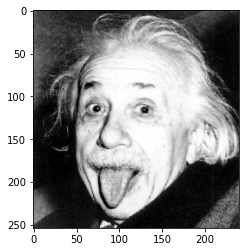

(254, 240)

In [62]:
image_rm = image_ss.copy()
image_rm[mask] = y_pred_rm
plt.imshow(image_rm, cmap='gray', vmin=0, vmax=255)
plt.show()
image_rm.shape

In [184]:
# gradient boosting
y_pred_gb = gradient_model.predict(X_test)
gb_mse = mean_squared_error(y_test, y_pred_gb)
print('mse for gradient boosting model is', gb_mse)


mse for gradient boosting model is 1532.9590912980918


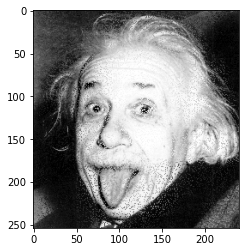

(254, 240)

In [64]:
image_gb = image_ss.copy()
image_gb[mask] = y_pred_gb
plt.imshow(image_gb, cmap='gray', vmin=0, vmax=255)
plt.show()
image_gb.shape

In [99]:
# feature map with gaussian
y_pred_fm = feature_model.predict(feature_map(X_test_01,x0_set,0.5))
fm_mse = mean_squared_error(y_test, y_pred_fm)
print('mse for feature map model is', fm_mse)


mse for feature map model is 3496.2154204413227


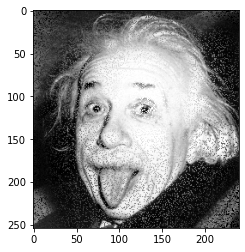

(254, 240)

In [100]:
image_fm = image_ss.copy()
image_fm[mask] = y_pred_fm
plt.imshow(image_fm, cmap='gray', vmin=0, vmax=255)
plt.show()
image_fm.shape

In [190]:
#d
from sklearn.linear_model import ElasticNet

def ela_net(alp,l1):
    regr = ElasticNet(random_state=0,alpha=alp, l1_ratio=l1)
    regr.fit(feature_map(X_train_01,x0_set,0.5), y_train)
    y_pred_en = regr.predict(feature_map(X_test_01,x0_set,0.5))
    en_mse = mean_squared_error(y_test, y_pred_en)
    return en_mse

alp_=0
l1_=0
mse_ = 8000
for alp in np.arange(0,1,0.1):
    for l1 in np.arange(0,1,0.1):
        kk = ela_net(alp,l1)
        if kk < mse_:
            alp_=alp
            l1_ = l1
            mse_ = kk

mse for elastic net regularization in feature map model is 7862.824373129346


In [197]:
print('mse for elastic net regularization in feature map model is', mse_)


mse for elastic net regularization in feature map model is 3564.8945080389854


The optimal parameter for elastic net regularization are actually 0, the mse was minimize when we use linear regression.

In [ ]:
#e

In [177]:
image_e = image_ss.copy()
image_ee = np.pad(image_e, pad_width=1, mode='constant', constant_values=-999)
image_ee = np.nan_to_num(image_ee,nan=-999)
row = image_ee.shape[0]
col = image_ee.shape[1]
up_ = np.ravel(image_ee[:row-2,1:col-1][~mask])
down_ = np.ravel(image_ee[2:row,1:col-1][~mask])
l_ = np.ravel(image_ee[1:row-1,:col-2][~mask])
r_ = np.ravel(image_ee[1:row-1,2:col][~mask])
X_train_e = np.array([X_train[:,0],X_train[:,1],up_,down_,l_,r_]).T

up_t = np.ravel(image_ee[:row-2,1:col-1][mask])
down_t = np.ravel(image_ee[2:row,1:col-1][mask])
l_t = np.ravel(image_ee[1:row-1,:col-2][mask])
r_t = np.ravel(image_ee[1:row-1,2:col][mask])
X_test_e = np.array([X_test[:,0],X_test[:,1],up_t,down_t,l_t,r_t]).T

In [201]:
forest_model_e = RandomForestRegressor(random_state=42)
forest_model_e.fit(X_train_e, y_train)

gradient_model_e = GradientBoostingRegressor(random_state=42)
gradient_model_e.fit(X_train_e, y_train)


X_train_e01 = (X_train_e - np.min(X_train_e)) / (np.max(X_train_e) - np.min(X_train_e))
X_test_e01 = (X_test_e - np.min(X_train_e)) / (np.max(X_train_e) - np.min(X_train_e))
x0_set_e = [X_train_e01[i] for i in kernel]
feature_model_e = LinearRegression()
feature_model_e.fit(feature_map(X_train_e01,x0_set_e,0.5), y_train)


LinearRegression()

In [202]:

RF_scores_e = cross_val_score(forest_model_e, X_train_e, y_train, scoring='neg_mean_squared_error')
print('Mean squared Error of Random forest', -RF_scores_e.mean())

GM_scores_e = cross_val_score(gradient_model_e, X_train_e, y_train, scoring='neg_mean_squared_error')
print('Mean squared Error of gradient model', -GM_scores_e.mean())

FM_scores_e = cross_val_score(feature_model_e, feature_map(X_train_e01,x0_set_e,0.5), y_train, scoring='neg_mean_squared_error')
print('Mean squared Error of feature map model', -FM_scores_e.mean())

Mean squared Error of Random forest 171.5989357684835
Mean squared Error of gradient model 233.87823716857505
Mean squared Error of feature map model 6599.650600364354


mse for random forest model is 152.16828312474098


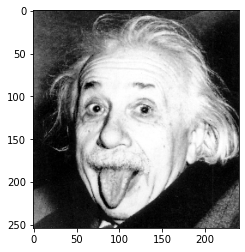

In [203]:
#c 
# random forest
y_pred_rm_e = forest_model_e.predict(X_test_e)
rm_mse_e = mean_squared_error(y_test, y_pred_rm_e)
print('mse for random forest model is', rm_mse_e)


image_rm_e = image_ss.copy()
image_rm_e[mask] = y_pred_rm_e
plt.imshow(image_rm_e, cmap='gray', vmin=0, vmax=255)
plt.show()



mse for gradient boosting model is 1532.9590912980918


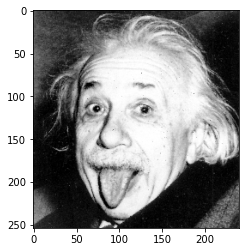

In [204]:

# gradient boosting
y_pred_gb_e = gradient_model_e.predict(X_test_e)
gb_mse_e = mean_squared_error(y_test, y_pred_gb_e)
print('mse for gradient boosting model is', gb_mse)


image_gb_e = image_ss.copy()
image_gb_e[mask] = y_pred_gb_e
plt.imshow(image_gb_e, cmap='gray', vmin=0, vmax=255)
plt.show()



mse for feature map model is 4594.37464366197


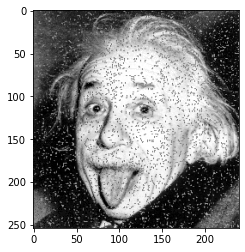

In [205]:

# feature map with gaussian
y_pred_fm_e = feature_model_e.predict(feature_map(X_test_e01,x0_set_e,0.5))
fm_mse_e = mean_squared_error(y_test, y_pred_fm_e)
print('mse for feature map model is', fm_mse_e)


image_fm_e = image_ss.copy()
image_fm_e[mask] = y_pred_fm_e
plt.imshow(image_fm_e, cmap='gray', vmin=0, vmax=255)
plt.show()
